In [1]:
### LIBRARIES
import numpy as np
import csv
import time
import pyvisa
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# OPEN TOP KEITHLEY 2450 (SERIAL NUMBER: 04386241)
rm = pyvisa.ResourceManager()
print(rm.list_resources())
sourceBiasVoltage = rm.open_resource('USB0::0x05E6::0x2450::04386241::INSTR') 

('USB0::0x05E6::0x2450::04386241::INSTR', 'ASRL3::INSTR')


In [3]:
# CSV FILE WRITE HANDLING
## FILE NAME AND LOCATION
filename = '[23-04-24]ECR_20sec_100mV_1V_01.csv'
folderpath = 'rawData/2023-04-11/'

## WRITE TO FILE
def csv_write(dataRow):
    with open(folderpath + filename, 'a', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(dataRow)
    f.close()

In [4]:

pLineFreq = 50              # Power line frequency in Denmark is 50 Hz
NPLC = 1                    # Amount of power line cycles for each measurement 
measTime = NPLC/pLineFreq   # Time that input signal is measured

expectedCurrRange = 1e-6    # Expected current measurement range.
                                # Fixed ranges are 10 nA, 100 nA, 1 µA, 10 µA, 100 µA, 1 mA, 10 mA, 100 mA, and 1 A.

voltSourceRange = 2         # Fixed ranges are 20 mV, 200 mV, 2 V, 20 V, and 200 V.

# FUNCTIONS

In [5]:
# VOLTAGE SOURCE CONFIGURATION
def sourceVoltageConf():


    sourceBiasVoltage.write("*RST")                     # Reset instrument

    # Source function, which can be voltage or current
    sourceBiasVoltage.write("SOUR:FUNC VOLT")           # :SOURce[1]:FUNCtion[:MODE]
                                                        # Voltage source function: VOLTage
                                                        # Current source function: CURRent

    # To determine if the instrument records the measured source value or the configured source 
    # value when making a measurement. We want measured (read back) value
    sourceBiasVoltage.write("SOUR:VOLT:READ:BACK ON")   # :SOURce[1]:<function>:READ:BACK
                                                        # Disable read back: 0 or OFF
                                                        # Enable read back: 1 or ON

In [6]:
# CURRENT MEASUREMENT CONFIGURATION
def senseCurrentConf():
    sourceBiasVoltage.write(":SENSe:CURRent:RSENse ON")             # 2-wire sensing for current measurements
    sourceBiasVoltage.write("TRAC:MAKE 'voltMeasBuffer', 50000")    # Create a user-defined reading buffer
                                                                    # :TRACe:MAKE "<bufferName>", <bufferSize>

    # The SENSe1 subsystem commands configure and control the measurement functions of the instrument.
    # Many of these commands are set for a specific function (current, voltage, or resistance). 
    # For example, you can program a range setting for each function. The settings are saved with that function.
    sourceBiasVoltage.write("SENS:FUNC 'CURR'")         # To select the active measure function
                                                        # [:SENSe[1]]:FUNCtion[:ON] "<function>"
                                                        # Current: CURRent[:DC]
                                                        # Resistance: RESistance
                                                        # Voltage: VOLTage[:DC]
    sourceBiasVoltage.write("SENS:CURR:NPLC %f" %NPLC)  # To set the time that the input signal is measured for the selected function
                                                        # [:SENSe[1]]:<function>:NPLCycles <n>
                                                        # [:SENSe[1]]:<function>:NPLCycles DEFault
                                                        # [:SENSe[1]]:<function>:NPLCycles MINimum
                                                        # [:SENSe[1]]:<function>:NPLCycles MAXimum                                           
    sourceBiasVoltage.write("SENS:COUNT 25")            # To set the number of measurements to make when a measurement is requested      
    
    # To determine the positive full-scale measure range. You can assign any real number using this command. 
    # The instrument selects the closest fixed range that is large enough to measure the entered number. 
    sourceBiasVoltage.write(":SENS:CURR:RANG %f" %expectedCurrRange) # [:SENSe[1]]:<function>:RANGe[:UPPer] <n>
                                                                    # [:SENSe[1]]:<function>:RANGe[:UPPer] DEFault
                                                                    # [:SENSe[1]]:<function>:RANGe[:UPPer] MINimum
                                                                    # [:SENSe[1]]:<function>:RANGe[:UPPer] MAXimum

    # Select the range for the source for the selected source function.
    # If you select a specific source range, the range must be large enough to source the value. If not, an overrange condition can occur.
    # If an overrange condition occurs, an event is displayed and the change to the setting is ignored.
    sourceBiasVoltage.write("SOUR:VOLT:RANG %f" %voltSourceRange)   # :SOURce[1]:<function>:RANGe <n>

    # Causes the instrument to refresh the reference and zero measurements once.
    sourceBiasVoltage.write(":SENS:AZERO:ONCE")

    sourceBiasVoltage.write(":SYSTEM:AZERO:STATE ON")

In [7]:
def sourceVoltageOutputEnable(enable): # Enable or disable the source output
    sourceBiasVoltage.write("OUTP " + str(enable))  # :OUTPut[1][:STATe] <state>                
                                                    # Turn source off: 0 or OFF
                                                    # Turn source on: 1 or ON
    if enable == 1:
        print("Output is ON")
    else:
        print("Output is OFF")

In [8]:
def measureIV():
    # [READing] to read the measured value
    # [SOURce] to read the applied bias
    # Read the source value. If readback is on, this is the actual applied voltage
    data = sourceBiasVoltage.query_ascii_values("READ? 'voltMeasBuffer', READ, SOUR")
    print(data, sep = "\n")

In [9]:
def clearBuffer():
    print("Clearing data buffer")
    sourceBiasVoltage.write(":TRACe:CLEar")
    time.sleep(2)
    print("Data buffer cleared")

In [10]:
# Initialize K2450's voltage source and current meter
def initialize():
    sourceVoltageConf()
    senseCurrentConf()
    time.sleep(1)
    print("Output enabled.")

# MAIN ROUTINE

In [12]:
# configure voltage source and current measurements
initialize()

# clear data buffer
clearBuffer()

# turn output on
sourceVoltageOutputEnable(1)

 # voltage bias parameters
minBias = 0                 # Initial bias step
maxBias = 1                 # Final bias step 
step = 0.1                  # Step
delay = 5                 # Delay between steps

bias = np.arange(minBias, maxBias+step, step)
print('Experiment has %d steps and will take %d seconds\n' % (len(bias), delay*len(bias)))

for steps in bias:
    sourceBiasVoltage.write("SOUR:VOLT %f" %steps)
    measureIV()
    time.sleep(delay)

print('Experiment done\n')

# turn output off
sourceVoltageOutputEnable(0)

Output enabled.
Clearing data buffer
Data buffer cleared
Output is ON
Experiment has 11 steps and will take 55 seconds

[6.590492e-12, -3.286067e-05]
[-1.274429e-11, -3.274696e-05]
[1.434984e-11, 0.09999683]
[2.796048e-11, 0.1999961]
[-8.673836e-12, 0.2999746]
[-2.148663e-13, 0.3999952]
[5.000406e-12, 0.4999903]
[-2.21573e-11, 0.6000101]
[-6.638615e-12, 0.69999]
[4.93677e-12, 0.7999786]


In [42]:
buffer_size = sourceBiasVoltage.query(":TRACe:ACTual? 'voltMeasBuffer'").strip('\n')
#while len(buffer_size) > 1:
 #   buffer_size = sourceBiasVoltage.query(":TRACe:ACTual? 'voltMeasBuffer'").strip('\n')
print(buffer_size)

275


In [44]:
buffer = list(sourceBiasVoltage.query(":TRACe:DATA? 1, 275, 'voltMeasBuffer', RELative, SOURce, READing").split(","))
print(len(buffer))

825


In [45]:
# Save data to ECR.csv
#sourceBiasVoltage.timeout = 5000
#csv_init()
buffer = list(sourceBiasVoltage.query(":TRACe:DATA? 1, 275, 'voltMeasBuffer', RELative, SOURce, READing").split(","))
#print(buffer)

ind = 0
elements = 3
while ind < len(buffer)/3:
    data = buffer[ind * elements : ind * elements + 3 : 1]
    csv_write(data)
    print(data)
    ind = ind + 1

['0.000000E+00', '-3.513343E-05', '3.461145E-09']
['8.248964E-02', '-3.411003E-05', '3.253523E-10']
['1.649732E-01', '-3.411002E-05', '1.675609E-10']
['2.474510E-01', '-3.263176E-05', '1.232954E-10']
['3.299423E-01', '-3.251806E-05', '8.068350E-11']
['4.124351E-01', '-3.240432E-05', '1.492119E-11']
['4.949121E-01', '-3.274547E-05', '-5.567510E-11']
['5.774030E-01', '-3.285917E-05', '-6.489725E-11']
['6.599004E-01', '-3.354146E-05', '-6.502446E-11']
['7.423854E-01', '-3.331405E-05', '-1.128195E-11']
['8.248746E-01', '-3.411003E-05', '4.964676E-11']
['9.073623E-01', '-3.320034E-05', '6.586474E-11']
['9.898410E-01', '-3.251806E-05', '4.150598E-11']
['1.072315E+00', '-3.308656E-05', '2.872234E-11']
['1.154796E+00', '-3.274546E-05', '-2.533753E-11']
['1.237275E+00', '-3.285917E-05', '-5.643831E-11']
['1.319763E+00', '-3.274544E-05', '-4.766135E-11']
['1.402255E+00', '-3.331404E-05', '-2.250766E-12']
['1.484740E+00', '-3.365515E-05', '3.641794E-11']
['1.567219E+00', '-3.331399E-05', '5.85506

Text(0.5, 0.98, 'ECR nanopore generation')

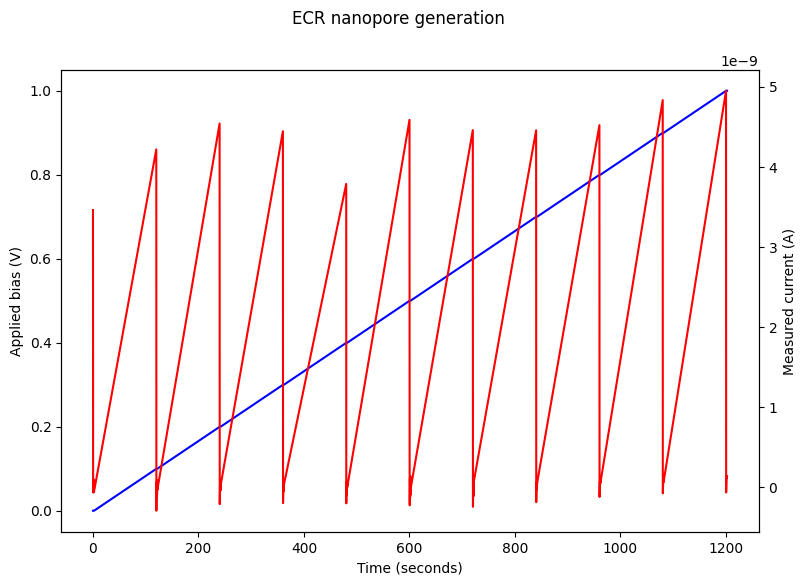

In [46]:
exp_time, exp_bias, exp_curr = [], [], []

for data in open(folderpath + filename, 'r'):
    seconds = float(data.split(",")[0])
    bias = float(data.split(",")[1])
    current = float(data.split(",")[2].strip('""\n'))
    
    exp_time.append(seconds)
    exp_bias.append(bias)
    exp_curr.append(current)
    
fig, bias_ax = plt.subplots(figsize=(9,6))
curr_ax = bias_ax.twinx()
bias_ax.plot(exp_time, exp_bias, 'b')
curr_ax.plot(exp_time, exp_curr, 'r')

bias_ax.set_xlabel('Time (seconds)')
bias_ax.set_ylabel('Applied bias (V)')
curr_ax.set_ylabel('Measured current (A)')
fig.suptitle("ECR nanopore generation")    